# Lab Customer Analysis Case Study

## Import libraries

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error #as mae
pd.options.display.max_rows = 50
from IPython.display import display, HTML

## Define functions to clean column labels before concating
 - all lower case
 - replace space with underscore

In [84]:
# create functions to rename and sort columns
# make columns lower case
def make_columns_lower_case(df):
    #df.columns=[i.lower() for i in df.columns]
    df.columns = df.columns.str.lower()
    return df

# replace space " " with underscore "_"
def replace_space(df):
    df.columns=[i.replace(" ","_") for i in df.columns]
    return df

# lower and replace space
def columns_lower_no_space(df):
    """ 
    Info: Columns of DataFrame will be manipulated: 
            1. All letters will be lowered.
            2. Spaces " " will be replaced with underscores "_"
    """
    make_columns_lower_case(df)
    replace_space(df)
    return df

### Load files and clean column names

In [85]:
# load data and store in variable
df = pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv", index_col=False)
df = columns_lower_no_space(df).drop(columns={"unnamed:_0"})

### Calculate percentage of NaN values and zero values in columns

##### ToDo: add columns for: type, No of categories, range, count, unique

In [86]:
# calculate percentage of NaN values and zero values in columns
#pd.DataFrame({"% NaN" : round(df.isna().sum()/len(df),4)*100, "% 0.0" : round(df[df == 0].count(axis=0)/len(df.index)* 100,2)})

### Clean data of individual columns

#### Clean data of column customer
##### Have a look at customer values
- show count and unique
- show duplicates

In [87]:
df.customer.describe()

count       10910
unique       9134
top       ID89933
freq            7
Name: customer, dtype: object

### Create function to show duplicates

#### ToDo: apply 2nd sort: index

In [88]:
def compare_duplicates( df = df, column = None  , amount = 10):
    ''' 
    compare_duplicates( DataFrame = df, column = none, amount = 10)
    
    column:     column to check for duplicated, if None > check all columns
    amount:     show first first amount of rows
    '''

    try:
        return df.loc[df.duplicated(subset=column, keep=False)].sort_values(by=column).head(amount)
    except KeyError:
        print("No duplicates")

### Compare duplicates in column customer
- same data?
- which one to keep? (last,first,none,all?)
- compare values in other columns to see inconsequent values or value pattern

In [89]:
# compare_duplicates(df, "customer", 10)

### Analyse duplicates
- customer duplicates are almost the same
- second duplicate is cleaner than the first.
- keep second

### Drop duplicates (based on customer column) and keep last
#### Drop column customer

In [90]:
## As there are  no nan-values we can
## Drop customer duplicates and keep last:
df = (df.drop_duplicates(subset = "customer", keep="last")
        .drop(["customer"], axis=1)
        .reset_index(drop=True))
#df.customer.describe()

### Filtering data and Correcting typos 
#### Filter the data in state and gender column to standardize the texts in those columns

#### Clean state column

In [91]:
#df.state.value_counts(dropna = False)

### Replacing null values
#### Replace missing values with means of the column (for numerical columns)

#### Overview of Nullvalues and NaN:

In [92]:
# calculate percentage of NaN values and zero values in columns
# pd.DataFrame({"% NaN" : round(df.isna().sum()/len(df),4)*100, "% 0.0" : round(df[df == 0].count(axis=0)/len(df.index)* 100,2)})

#### Eliminate 0-values in income with calculated mean

In [93]:
# have a look at income values
#df.income.value_counts(dropna = False)

#### Calculate mean of income but ignore 0

In [94]:
# calculate mean of income without zero
# mean_income_no_zero = df.income.sum()/(df.income.fillna(0).astype(bool).sum())
# mean_income_no_zero

In [95]:
# replace 0.0-values with mean_income_no_zero
#df.income = list(map(lambda x: mean_income_no_zero if x == 0.0 else x, df.income))

In [96]:
# Instead of filling in mean replace 0 with last valiable value
df.income = df.income.replace(to_replace=0, method='bfill').replace(to_replace=0, method='ffill')

In [97]:
## drop columns with less values
df = df.drop(columns={'vehicle_type'})

In [98]:
## drop rows with no state and response
df = df.dropna(how="any")
df = df.reset_index().drop(columns={"index"})

In [99]:
# check NaN and 0.0 again
pd.DataFrame({"% NaN" : round(df.isna().sum()/len(df),4)*100, "% 0.0" : round(df[df == 0].count(axis=0)/len(df.index)* 100,2)})

,% NaN,% 0.0
state,0.00,0.00
customer_lifetime_value,0.00,0.00
response,0.00,0.00
coverage,0.00,0.00
education,0.00,0.00
effective_to_date,0.00,0.00
employmentstatus,0.00,0.00
gender,0.00,0.00
income,0.00,0.00
location_code,0.00,0.00


# Activity 2

## Bucketing the data - Write a function to replace column "State" to different zones. California as West Region, Oregon as North West, and Washington as East, and Arizona and Nevada as Central

### create function to rename values. Use dataframe as input and a dict as a renaming advice

In [100]:
# def function to rename values
def rename_values( x , dict ):
    if x in dict.keys():
        return x
    for key, list_substitutes in dict.items():
        if x in list_substitutes:
            return key
    return

In [101]:
# create Dic with valiable values for state as keys and and likely missspelled values as a list of values
replace_state_region_dic = {'West Region' : ["California"], 'North West' : ["Oregon"] , 'East' : ["Washington"] , 'Central': ["Nevada","Arizona"] }

# use rename funcion on df.state
df["region"] = list(map(lambda x: rename_values(x,replace_state_region_dic), df.state))
# df.region.value_counts()

## Standardizing the data – Use string functions to standardize the text data (lower case)

In [102]:
# make all string lower case
df = df.applymap(lambda x: x if type(x)!=str else x.lower())

- Plot the Correlation Heatmap.


In [103]:
#sns.heatmap(df.corr())

In [104]:
#sns.pairplot(df)

### Activity 5

- Check the data types of the columns. Get the numeric data into dataframe called `numerical` and categorical columns in a dataframe called `categoricals`.
(You can use np.number and np.object to select the numerical data types and categorical data types respectively)


In [105]:
numerical = df.select_dtypes([float,int])
#numerical = numerical.drop(columns = ['number_of_open_complaints','number_of_policies'])
#numerical

In [106]:
categoricals = df.select_dtypes([object])
categoricals = categoricals.drop(columns=['effective_to_date','state'])
#categoricals[['number_of_open_complaints','number_of_policies']] = df[['number_of_open_complaints','number_of_policies']]
#categoricals

Removing outliers

C:\ProgramData\Anaconda3\envs\DA_Env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='customer_lifetime_value'>

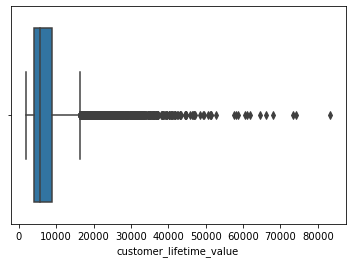

In [107]:
sns.boxplot(numerical.customer_lifetime_value)

In [108]:
Q1 = numerical.customer_lifetime_value.quantile(0.25)
Q3 = numerical.customer_lifetime_value.quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.

In [109]:
filter = (numerical["customer_lifetime_value"] >= Q1 - 1.5 * IQR) & (numerical["customer_lifetime_value"] <= Q3 + 1.5 *IQR)
numerical = numerical.loc[filter] 

C:\ProgramData\Anaconda3\envs\DA_Env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='customer_lifetime_value'>

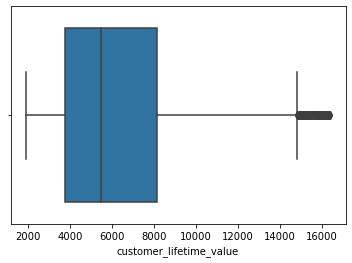

In [110]:
sns.boxplot(numerical.customer_lifetime_value)

<AxesSubplot:>

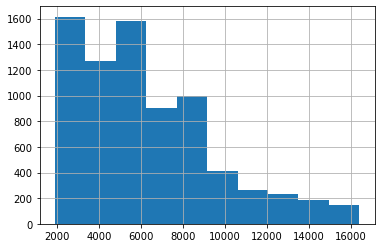

In [111]:
numerical.customer_lifetime_value.hist()

## Activity 6

  

 #### X-y split.
  

In [112]:
# separate x and y
#x = df.drop(columns=['total_claim_amount'],axis=1)
x = numerical.drop(columns=['total_claim_amount'],axis=1)
y = numerical.total_claim_amount 

 #### Normalize (numerical).
  

In [113]:
# get only numeric
x_num=x

In [114]:
# x_num.hist(figsize=(12,12))

In [115]:
# normalize with standard Scaler
x_standard_scaled=StandardScaler().fit_transform(x_num)
# x_standard_scaled.shape

In [116]:
# pd.DataFrame(x_standard_scaled).hist(figsize=(12,12))

In [117]:
# Standardize using Power Transformer
x_power_trans = PowerTransformer().fit_transform(x_num)
# x_power_trans.shape

In [118]:
# pd.DataFrame(x_power_trans).hist(figsize=(12,12))

### One Hot/Label Encoding (categorical).


In [119]:
categoricals_dummies = pd.get_dummies(categoricals, drop_first=True)
# categoricals_dummies

In [120]:
# categoricals.columns

In [121]:
list_cat = []
for i in categoricals.columns:
    list_cat.append(list(categoricals.loc[:,i].unique()))
# list_cat


In [122]:
Ordinal_Cats = [['no','yes'],
['basic','extended','premium'],
['high school or below','college','bachelor','master','doctor'],
['unemployed','employed','disabled','medical leave','retired'],
['f','m'],
['urban','suburban','rural'],
['single','married','divorced'],
['personal auto', 'corporate auto', 'special auto'], 
['personal l1','personal l2', 'personal l3',      'corporate l1',  'corporate l2', 'corporate l3', 'special l1', 'special l2',  'special l3' ], 
['offer4', 'offer3', 'offer2', 'offer1'], 
['call center', 'branch', 'agent', 'web'], 
['four-door car',  'suv',  'two-door car',  'sports car',  'luxury car',  'luxury suv'],
['small', 'medsize', 'large'], 
['north west','west region','central', 'east']]#,
#[0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
#[1, 2, 3, 4, 5, 6, 7, 8, 9]]
 
#Ordinal_Cats


In [123]:
categoricals_ordinal = pd.DataFrame(OrdinalEncoder(categories = Ordinal_Cats).fit_transform(categoricals), columns = categoricals.columns)
# categoricals_ordinal

### Modelling

In [124]:
def model_performance(y_train, y_pred_train, y_test, y_pred_test):

    ME_train = np.mean(y_train-y_pred_train)
    ME_test  = np.mean(y_test-y_pred_test)

    MAE_train = mean_absolute_error(y_train,y_pred_train)
    MAE_test  = mean_absolute_error(y_test,y_pred_test)

    MSE_train = mse(y_train,y_pred_train)
    MSE_test  = mse(y_test,y_pred_test)

    RMSE_train = np.sqrt(MSE_train)
    RMSE_test  = np.sqrt(MSE_test)

    MAPE_train = np.mean((np.abs(y_train-y_pred_train) / y_train)* 100.)
    MAPE_test  = np.mean((np.abs(y_test-y_pred_test) / y_test)* 100.)

    R2_train = r2_score(y_train,y_pred_train)
    R2_test  = r2_score(y_test,y_pred_test)

    performance = pd.DataFrame({'Error_metric': ['Mean error','Mean absolute error','Mean squared error',
                                             'Root mean squared error','Mean absolute percentual error',
                                             'R2'],
                            'Train': [ME_train, MAE_train, MSE_train, RMSE_train, MAPE_train, R2_train],
                            'Test' : [ME_test, MAE_test , MSE_test, RMSE_test, MAPE_test, R2_test]})

    pd.options.display.float_format = '{:.2f}'.format

    df_train = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_train})
    df_test  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred_test})

    return performance, df_train, df_test

In [156]:
def split_scale(df,y_column):
    ''' Input: df
        Output: X_train_scaled, X_test_scaled, y_train, y_test as tuple
        Enter via split_scale(df)[i]
    '''
    df = df._get_numeric_data()
    X = df.drop(y_column,axis=1)
    y = df[y_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,random_state=123)
    std_scaler=StandardScaler().fit(X_train) 
    X_train_scaled=std_scaler.transform(X_train)
    X_test_scaled=std_scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, index = X_train.index, columns = X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index = X_test.index, columns = X_test.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test

def apply_model(X_train, X_test, y_train, y_test, model, constant=False):#,feature_elimination=False):
    
    if constant == True:
        try:
            X_train = sm.add_constant(X_train) # adding a constant
            X_test = sm.add_constant(X_test) # adding a constant
        except:
            pass
    print(model)
    # if feature_elimination:
    #     model = RFE(model,n_features_to_select = 3, step = 1, verbose=1)
    #     model.fit(X_train,y_train)
    #     print(X_train.columns)
    # else:
    model.fit( X_train,y_train)
    y_pred_train = model.predict(X_train)  
    y_pred_test = model.predict(X_test)
    try:
        print_model = model.summary()
        print(print_model)
    except: 
        m_p = model_performance(y_train, y_pred_train, y_test, y_pred_test)
        display(HTML(m_p[0].to_html()))

    return y_pred_train, y_pred_test, y_train, y_test, model

def plot_model(predictions_train, predictions_test, y_train, y_test):
    # Make an scatter plot y_pred vs y
    # What kind of plot you will get if all the all the predictions are ok?
    # A stright line

    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax[0,0].plot(predictions_test, y_test, 'o',color='#2499be')
    ax[0,0].set_xlabel("y_test")
    ax[0,0].set_ylabel("y_pred")
    ax[0,0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[0,1].hist(y_test - predictions_test,color='#2499be')
    ax[0,1].set_xlabel("Test y-y_pred")
    ax[0,1].set_title("Test Set Residual histogram")

    ax[1,0].plot(predictions_train, y_train, 'o',color='#2499be')
    ax[1,0].set_xlabel("y_train")
    ax[1,0].set_ylabel("y_pred_train")
    ax[1,0].set_title("Train set Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1,1].hist(y_train -predictions_train,color='#2499be')
    ax[1,1].set_xlabel("Train y-y_pred")
    ax[1,1].set_title("Train Residual histogram")
    return
    
def model_df(df,y_column, model_function, constant = False):#,feature_elimination = False):
    df_scaled = split_scale(df,y_column)
    model = apply_model(df_scaled[0],df_scaled[1],df_scaled[2],df_scaled[3],model_function,constant)#,feature_elimination)
    plot_model(model[0],model[1],model[2],model[3])
    return model[4]

In [157]:
df = numerical.merge(categoricals_dummies,how='inner',left_index=True,right_index=True)
df.head()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,response_yes,coverage_extended,...,vehicle_class_luxury car,vehicle_class_luxury suv,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,vehicle_size_medsize,vehicle_size_small,region_east,region_north west,region_west region
0,2228.53,22139,64,3.00,26,0.00,1,744.92,0,0,...,0,0,0,0,0,1,0,0,0,1
1,14947.92,22139,100,34.00,31,0.00,2,480.00,0,0,...,0,0,0,1,0,1,0,1,0,0
3,5035.04,37405,63,8.00,99,3.00,4,287.56,0,0,...,0,0,0,0,0,1,0,0,0,1
4,4956.25,87197,63,35.00,45,0.00,3,247.40,0,0,...,0,0,0,0,1,1,0,0,0,1
5,5989.77,66839,154,33.00,24,0.00,1,739.20,1,0,...,0,0,1,0,0,1,0,0,0,1


In [158]:
model = [LinearRegression(),Lasso(alpha=20),Ridge(alpha=20),KNeighborsRegressor()]

LinearRegression()


,Error_metric,Train,Test
0,Mean error,-0.00,0.02
1,Mean absolute error,91.96,90.39
2,Mean squared error,17817.35,16451.10
3,Root mean squared error,133.48,128.26
4,Mean absolute percentual error,101.07,68.91
5,R2,0.77,0.76


Lasso(alpha=20)


,Error_metric,Train,Test
0,Mean error,0.00,0.38
1,Mean absolute error,97.06,93.68
2,Mean squared error,20956.21,18707.23
3,Root mean squared error,144.76,136.77
4,Mean absolute percentual error,150.31,87.31
5,R2,0.73,0.73


Ridge(alpha=20)


,Error_metric,Train,Test
0,Mean error,0.00,0.04
1,Mean absolute error,91.71,90.09
2,Mean squared error,17827.55,16409.30
3,Root mean squared error,133.52,128.10
4,Mean absolute percentual error,101.83,68.99
5,R2,0.77,0.76


KNeighborsRegressor()


,Error_metric,Train,Test
0,Mean error,8.48,12.83
1,Mean absolute error,94.97,114.98
2,Mean squared error,19291.65,27014.49
3,Root mean squared error,138.89,164.36
4,Mean absolute percentual error,140.94,119.26
5,R2,0.75,0.61


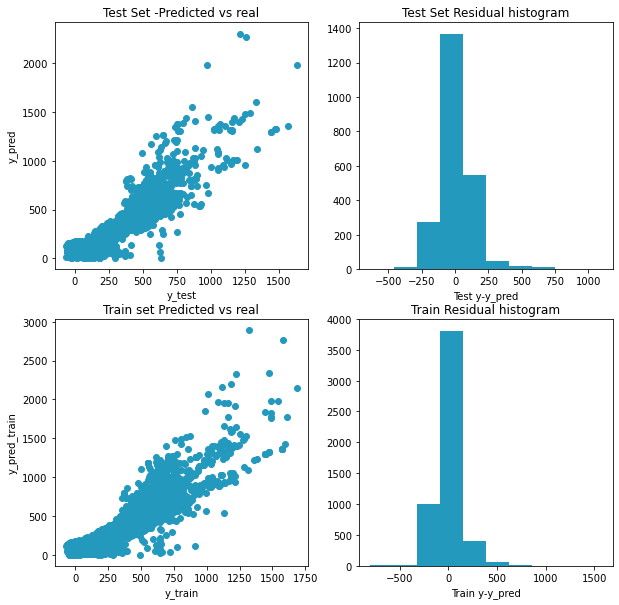

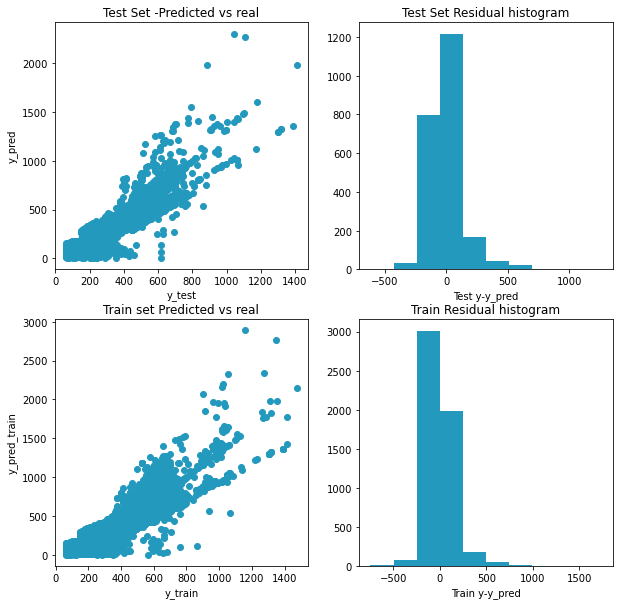

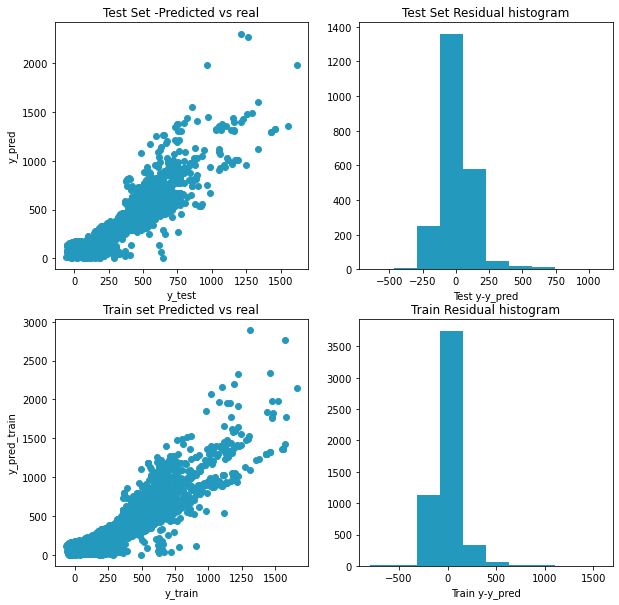

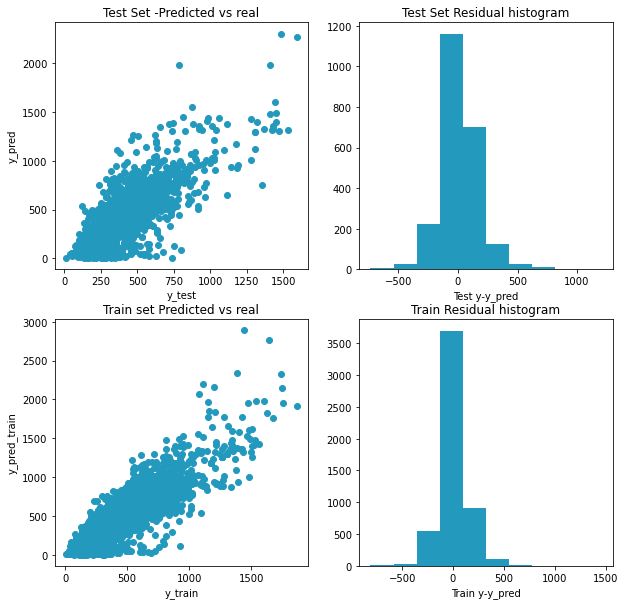

In [159]:
for i in model:
    model_df(df,'total_claim_amount',i,False)

In [183]:
def split_scale(df,y_column):
    ''' Input: df
        Output: X_train_scaled, X_test_scaled, y_train, y_test as tuple
        Enter via split_scale(df)[i]
    '''
    df = df._get_numeric_data()
    X = df.drop(y_column,axis=1)
    y = df[y_column]
    transformer = PolynomialFeatures(degree=2, include_bias=False)
    transformer.fit(X)
    X= transformer.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,random_state=123)#
    std_scaler=StandardScaler().fit(X_train) 
    X_train_scaled=std_scaler.transform(X_train)
    X_test_scaled=std_scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled)#, index = X_train.index, columns = X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled)#, index = X_test.index, columns = X_test.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test

def apply_model(X_train, X_test, y_train, y_test, model, constant=False,feature_elimination=False):
    
    if constant == True:
        try:
            X_train = sm.add_constant(X_train) # adding a constant
            X_test = sm.add_constant(X_test) # adding a constant
        except:
            pass
    print(model)
    if feature_elimination:
        model = RFE(model,n_features_to_select = 15, step = 20, verbose=1)
        model.fit(X_train,y_train)
        
    else:
        model.fit( X_train,y_train)
    y_pred_train = model.predict(X_train)  
    y_pred_test = model.predict(X_test)
    try:
        print_model = model.summary()
        print(print_model)
    except: 
        m_p = model_performance(y_train, y_pred_train, y_test, y_pred_test)
        display(HTML(m_p[0].to_html()))

    return y_pred_train, y_pred_test, y_train, y_test, model

def plot_model(predictions_train, predictions_test, y_train, y_test):
    # Make an scatter plot y_pred vs y
    # What kind of plot you will get if all the all the predictions are ok?
    # A stright line

    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax[0,0].plot(predictions_test, y_test, 'o',color='#2499be')
    ax[0,0].set_xlabel("y_test")
    ax[0,0].set_ylabel("y_pred")
    ax[0,0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[0,1].hist(y_test - predictions_test,color='#2499be')
    ax[0,1].set_xlabel("Test y-y_pred")
    ax[0,1].set_title("Test Set Residual histogram")

    ax[1,0].plot(predictions_train, y_train, 'o',color='#2499be')
    ax[1,0].set_xlabel("y_train")
    ax[1,0].set_ylabel("y_pred_train")
    ax[1,0].set_title("Train set Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1,1].hist(y_train -predictions_train,color='#2499be')
    ax[1,1].set_xlabel("Train y-y_pred")
    ax[1,1].set_title("Train Residual histogram")
    return
    
def model_df(df,y_column, model_function, constant = False,feature_elimination = False):
    df_scaled = split_scale(df,y_column)
    model = apply_model(df_scaled[0],df_scaled[1],df_scaled[2],df_scaled[3],model_function,constant,feature_elimination)
    plot_model(model[0],model[1],model[2],model[3])
    return model[4]

In [184]:
model = [LinearRegression(),Lasso(alpha=20),Ridge(alpha=20)]

LinearRegression()
Fitting estimator with 1274 features.
Fitting estimator with 1254 features.
Fitting estimator with 1234 features.
Fitting estimator with 1214 features.
Fitting estimator with 1194 features.
Fitting estimator with 1174 features.
Fitting estimator with 1154 features.
Fitting estimator with 1134 features.
Fitting estimator with 1114 features.
Fitting estimator with 1094 features.
Fitting estimator with 1074 features.
Fitting estimator with 1054 features.
Fitting estimator with 1034 features.
Fitting estimator with 1014 features.
Fitting estimator with 994 features.
Fitting estimator with 974 features.
Fitting estimator with 954 features.
Fitting estimator with 934 features.
Fitting estimator with 914 features.
Fitting estimator with 894 features.
Fitting estimator with 874 features.
Fitting estimator with 854 features.
Fitting estimator with 834 features.
Fitting estimator with 814 features.
Fitting estimator with 794 features.
Fitting estimator with 774 features.
Fitti

,Error_metric,Train,Test
0,Mean error,-0.00,-0.55
1,Mean absolute error,143.39,138.31
2,Mean squared error,39504.21,34224.22
3,Root mean squared error,198.76,185.00
4,Mean absolute percentual error,191.87,96.09
5,R2,0.49,0.51


Lasso(alpha=20)
Fitting estimator with 1274 features.
Fitting estimator with 1254 features.
Fitting estimator with 1234 features.
Fitting estimator with 1214 features.
Fitting estimator with 1194 features.
Fitting estimator with 1174 features.
Fitting estimator with 1154 features.
Fitting estimator with 1134 features.
Fitting estimator with 1114 features.
Fitting estimator with 1094 features.
Fitting estimator with 1074 features.
Fitting estimator with 1054 features.
Fitting estimator with 1034 features.
Fitting estimator with 1014 features.
Fitting estimator with 994 features.
Fitting estimator with 974 features.
Fitting estimator with 954 features.
Fitting estimator with 934 features.
Fitting estimator with 914 features.
Fitting estimator with 894 features.
Fitting estimator with 874 features.
Fitting estimator with 854 features.
Fitting estimator with 834 features.
Fitting estimator with 814 features.
Fitting estimator with 794 features.
Fitting estimator with 774 features.
Fitting 

,Error_metric,Train,Test
0,Mean error,-0.00,-0.42
1,Mean absolute error,85.40,81.39
2,Mean squared error,15705.99,13994.84
3,Root mean squared error,125.32,118.30
4,Mean absolute percentual error,131.13,72.45
5,R2,0.80,0.80


Ridge(alpha=20)
Fitting estimator with 1274 features.
Fitting estimator with 1254 features.
Fitting estimator with 1234 features.
Fitting estimator with 1214 features.
Fitting estimator with 1194 features.
Fitting estimator with 1174 features.
Fitting estimator with 1154 features.
Fitting estimator with 1134 features.
Fitting estimator with 1114 features.
Fitting estimator with 1094 features.
Fitting estimator with 1074 features.
Fitting estimator with 1054 features.
Fitting estimator with 1034 features.
Fitting estimator with 1014 features.
Fitting estimator with 994 features.
Fitting estimator with 974 features.
Fitting estimator with 954 features.
Fitting estimator with 934 features.
Fitting estimator with 914 features.
Fitting estimator with 894 features.
Fitting estimator with 874 features.
Fitting estimator with 854 features.
Fitting estimator with 834 features.
Fitting estimator with 814 features.
Fitting estimator with 794 features.
Fitting estimator with 774 features.
Fitting 

,Error_metric,Train,Test
0,Mean error,-0.00,0.05
1,Mean absolute error,77.03,73.38
2,Mean squared error,13280.25,12266.08
3,Root mean squared error,115.24,110.75
4,Mean absolute percentual error,81.98,49.04
5,R2,0.83,0.82


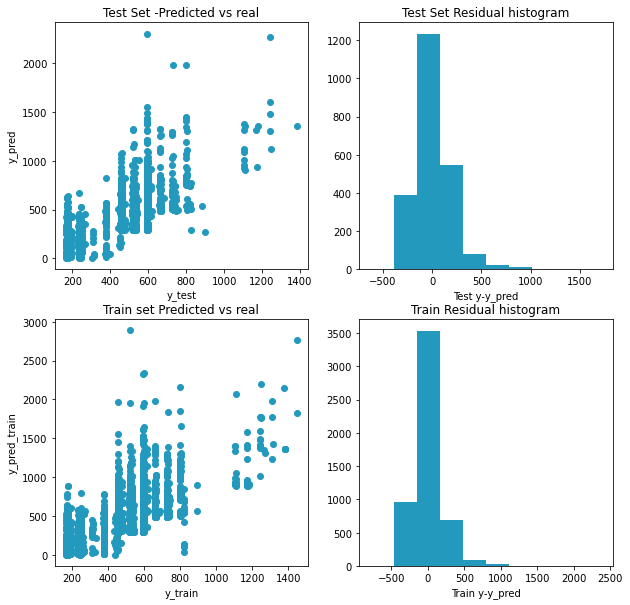

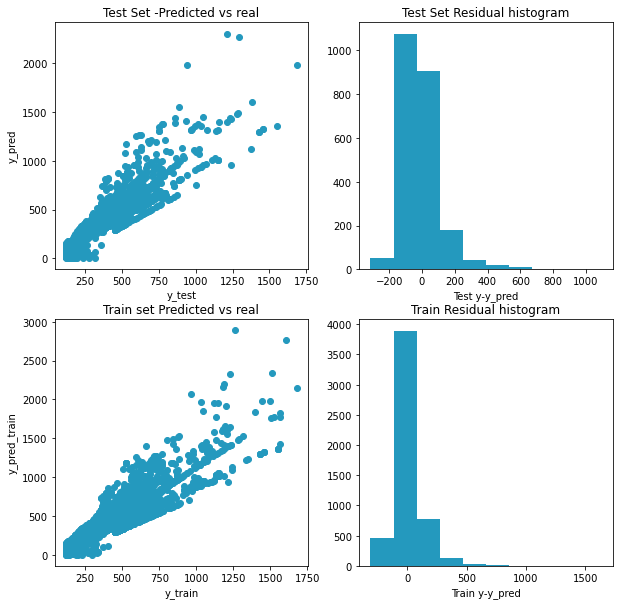

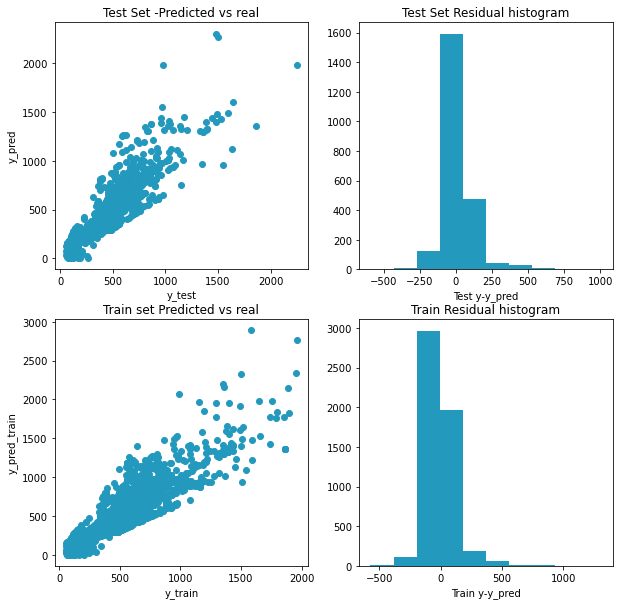

In [185]:
for i in model:
    model_df(df,'total_claim_amount',i,False,True)